<a href="https://colab.research.google.com/github/lazarod2311/Fake-News-classification-using-NLP-with-LSTM-neural-network/blob/main/Notebooks/NLP_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Montando a pasta do Google Drive para acessar os arquivos.


In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importando as Bibliotecas necessárias para a tarefa.

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import text_to_word_sequence
import re, os
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm
import glob
from pathlib import Path
import nltk
from unidecode import unidecode
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from numba import cuda

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Verificando se todos os arquivos estão nas pastas. São 7200 arquivos em cada uma, sendo 3600 referentes aos textos e 3600 aos metadados.

In [ ]:
arquivos_fake = os.listdir("/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/fake")
arquivos_real = os.listdir("/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/true")
print("Quantidade de arquivos fake: " + str(len(arquivos_fake)))
print("Quantidade de arquivos reais: " + str(len(arquivos_real)))

Quantidade de arquivos fake: 7200
Quantidade de arquivos reais: 7200


Função para tratar os diretórios

In [ ]:
def get_text_files(list1, list2):
  return [i for i in list1 if i not in list2]

In [ ]:
fake_text_files = glob.glob(f"/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/fake/*.txt")
fake_meta_files = glob.glob(f"/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/fake/*-meta.txt")
fake_text_files = get_text_files(fake_text_files, fake_meta_files)
real_text_files = glob.glob(f"/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/true/*.txt")
real_meta_files = glob.glob(f"/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/true/*-meta.txt")
real_text_files = get_text_files(real_text_files, real_meta_files)


Lendo os arquivos e criando o dataframe

In [ ]:
def read_files(files_dir, meta_dir, tag):
  rotules = open(f"/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/rotules.txt").readlines()
  rotules = [line.rstrip() for line in rotules]
  data = {'id': list() , 'Tag': list(), 'full_text': list()}
  for j in range(len(rotules)):
      data[rotules[j]] = list()
  for i in tqdm(files_dir):
    meta_dir = i
    meta_dir = re.sub('.txt', '-meta.txt', meta_dir)
    lines = open(meta_dir).readlines()
    lines = [line.rstrip() for line in lines]
    text = open(i).read()
    data['id'].append((str(Path(i).stem) + "-" + tag))
    data['Tag'].append(tag)
    data['full_text'].append(text)
    for j in range(len(rotules)):
      data[rotules[j]].append(lines[j])
  df_out = pd.DataFrame(data)

  return df_out


In [ ]:
df_fake = read_files(fake_text_files,fake_meta_files, "FAKE")
df_real = read_files(real_text_files,real_meta_files, "REAL")



100%|██████████| 3600/3600 [00:06<00:00, 550.60it/s]


In [ ]:
df_real

,id,Tag,full_text,author,link,category,date of publication,number of tokens,number of words without punctuation,number of types,...,number of singular first and second personal pronouns,number of plural first personal pronouns,number of pronouns,pausality,number of characters,average sentence length,average word length,percentage of news with speeling errors,emotiveness,diversity
0,548-REAL,REAL,Ministros Barroso e Gilmar Mendes trocam acusa...,"Por Renan Ramalho, G1, Brasília",https://g1.globo.com/politica/noticia/ministro...,politica,26/10/2017 19h33,512,442,244,...,2,0,22,2.59259,2244,16.3704,5.07692,0.0,0.206731,0.552036
1,549-REAL,REAL,Autor do texto que regulamenta serviços como o...,"Por Alessandra Modzeleski, G1, Brasília",https://g1.globo.com/politica/noticia/autor-do...,tv_celebridades,31/10/2017 16h08,622,530,253,...,0,0,34,3.06667,2588,17.6667,4.88302,0.00188679,0.207317,0.477358
2,55-REAL,REAL,Gilmar Mendes manda tirar tornozeleira eletrôn...,Marcelo Parreira,https://g1.globo.com/politica/noticia/gilmar-m...,politica,22/12/2017,345,302,163,...,0,0,13,3.30769,1701,23.2308,5.63245,0.00331126,0.180556,0.539735
3,550-REAL,REAL,Comunidade internacional condena Coreia do Nor...,Por G1,https://g1.globo.com/mundo/noticia/comunidade-...,sociedade_cotidiano,03/09/2017 08h29,1303,1143,476,...,0,1,45,3.2,5894,22.86,5.15661,0.0,0.32766,0.416448
4,551-REAL,REAL,Temer embarca para passar o carnaval em base n...,"Por Guilherme Mazui e Roniara Castilhos, G1 e...",https://g1.globo.com/politica/noticia/temer-em...,politica,10/02/2018 10h45,599,519,251,...,0,0,14,2.85714,2527,18.5357,4.86898,0.0,0.14978,0.483622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,1084-REAL,REAL,Receita de vilarejos italianos para não desapa...,Por BBC,https://g1.globo.com/brasil/noticia/receita-de...,sociedade_cotidiano,31/10/2017 13h58,1708,1491,660,...,1,0,64,3.14493,7666,21.6087,5.14152,0.00201207,0.312303,0.442656
3596,1085-REAL,REAL,"Ainda tinha esperança que ela sobrevivesse, di...",Por Bom Dia Cidade,https://g1.globo.com/sp/sao-carlos-regiao/noti...,sociedade_cotidiano,12/03/2018 10h28,881,758,370,...,6,0,53,2.73333,3500,16.8444,4.61741,0.00131926,0.158824,0.488127
3597,1086-REAL,REAL,"Vamos nos lembrar de Meditações VII , de John...",José Nêumanne,http://politica.estadao.com.br/blogs/neumanne/...,politica,01 de agosto de 2017,2239,1978,861,...,6,3,112,3.18293,9428,24.122,4.76643,0.00303337,0.184598,0.435288
3598,1087-REAL,REAL,"‘Maia não será candidato do governo’, diz ACM ...","Igor Gadelha e Isadora Peron, O Estado de S.P...","http://politica.estadao.com.br/noticias/geral,...",politica,08 de março de 2018,1728,1504,593,...,3,2,155,3.29412,7031,22.1176,4.67487,0.0,0.29822,0.394282


In [ ]:
df_full = pd.concat([df_real, df_fake], ignore_index=True)

Tratando os dados

In [ ]:
def clean_str(string):
    string = unidecode(string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub('[^a-zA-z0-9\s]','',string)

    cleanr = re.compile('<.*?>')

    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')


    return string.strip().lower()

In [ ]:
df_full['normalized_text'] = df_full['full_text'].apply(lambda x: x.lower())
df_full['normalized_text'] = df_full['full_text'].apply(lambda x: clean_str(x))

Salvando os dados em CSV

In [ ]:
df_full.to_csv(f"/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/all_data.csv", sep="|", encoding= "utf-8", index=False)

Lendo os dados do arquivo .csv criado

In [ ]:
data = pd.read_csv(f"/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/all_data.csv", sep="|", encoding="utf-8")

Verificando os dados

In [ ]:
print(data)

             id   Tag                                          full_text  \
0      548-REAL  REAL  Ministros Barroso e Gilmar Mendes trocam acusa...   
1      549-REAL  REAL  Autor do texto que regulamenta serviços como o...   
2       55-REAL  REAL  Gilmar Mendes manda tirar tornozeleira eletrôn...   
3      550-REAL  REAL  Comunidade internacional condena Coreia do Nor...   
4      551-REAL  REAL  Temer embarca para passar o carnaval em base n...   
...         ...   ...                                                ...   
7195  1084-FAKE  FAKE  Mais um vídeo! Funcionária filma ator descontr...   
7196  1085-FAKE  FAKE  Ator global é preso por desacato. Ele estava a...   
7197  1086-FAKE  FAKE  "Plano de fuga volta a ser cogitado caso Sérgi...   
7198  1087-FAKE  FAKE  Cortella analisa personalidades de 2017: "Mich...   
7199  1088-FAKE  FAKE  "Avião com 500 kg de cocaína decolou de fazend...   

                                                 author  \
0                       Por 

In [ ]:
seed = 7
np.random.seed(seed)

In [ ]:
print(data['normalized_text'])

0       ministros barroso e gilmar mendes trocam acusa...
1       autor do texto que regulamenta servicos como o...
2       gilmar mendes manda tirar tornozeleira eletron...
3       comunidade internacional condena coreia do nor...
4       temer embarca para passar o carnaval em base n...
                              ...                        
7195    mais um video funcionaria filma ator descontro...
7196    ator global e preso por desacato ele estava al...
7197    plano de fuga volta a ser cogitado caso sergio...
7198    cortella analisa personalidades de michel teme...
7199    aviao com kg de cocaina decolou de fazenda arr...
Name: normalized_text, Length: 7200, dtype: object


In [ ]:
print(data['Tag'].unique())

['REAL' 'FAKE']


In [ ]:
stopwords.words('portuguese')

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [ ]:
def get_words(data):
  stop_words = set(stopwords.words('portuguese'))
  stop_words = [unidecode(s) for s in stop_words]
  text = []
  text_aux = []
  text_categ = {}
  for tag in list(data['Tag'].unique()):
    mask = data['Tag'] == tag
    data_aux = data[mask]
    for row in data_aux['normalized_text'].values:
      word_list = text_to_word_sequence(row)
      no_stop_words = [w for w in word_list if not w in stop_words]
      no_stop_words = " ".join(no_stop_words)
      text_aux.append(no_stop_words)
    text_categ[tag] = text_aux
    text_aux = []
  for row in data['normalized_text'].values:
    word_list = text_to_word_sequence(row)
    no_stop_words = [w for w in word_list if not w in stop_words]
    no_stop_words = " ".join(no_stop_words)
    text.append(no_stop_words)
  
  return text, text_categ

In [ ]:
def tf_idf(data):
  tfIdfVectorizer=TfidfVectorizer(use_idf=True)
  tfIdf = tfIdfVectorizer.fit_transform(data)
  df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names_out(), columns=["TF-IDF"])
  df = df.sort_values('TF-IDF', ascending=False)
  print (df.head(25))

In [ ]:
total_words, class_words = get_words(data)

In [ ]:
tf_idf(class_words['REAL'])

               TF-IDF
barroso      0.500567
gilmar       0.355508
mendes       0.236291
vossa        0.216518
discussao    0.189930
excelencia   0.187075
colarinho    0.164006
dirceu       0.142210
branco       0.116986
raiva        0.102807
respondeu    0.099948
soltar       0.096164
alguem       0.089017
odio         0.086420
ministros    0.083868
mensalao     0.082853
parceria     0.079841
transfira    0.078509
destilando   0.078509
hehehe       0.078509
colega       0.075607
treplicou    0.073552
mentia       0.073552
compromisso  0.072882
jose         0.072011


In [ ]:
tf_idf(class_words['FAKE'])

               TF-IDF
barroso      0.530167
gilmar       0.236385
mendes       0.232512
vossa        0.194246
excelencia   0.189935
mentira      0.187032
odio         0.187032
trabalha     0.177433
ganharem     0.141736
destilar     0.141736
torcemos     0.141736
prendemos    0.134972
mocinhos     0.134972
destilando   0.130172
brigando     0.126450
extincao     0.110509
municipios   0.108121
ceara        0.106033
solta        0.104178
tomando      0.103322
acompanha    0.103322
imagine      0.102508
professora   0.099599
normalmente  0.098945
bate         0.097709


O modelo TF-IDF mostra que não há stopwords nos arquivos, sendo bem sucedido o tratamento anterior, então devemos capturar os índices para obter o conjunto de palavras utilizado em cada classificação posteriormente.

In [ ]:
fake_index = data[data['Tag'] == 'FAKE'].index.values.tolist()
real_index = data[data['Tag'] == 'REAL'].index.values.tolist()

In [ ]:
tokenizer = Tokenizer(num_words=6000, split=' ')

tokenizer.fit_on_texts(total_words)
X = tokenizer.texts_to_sequences(total_words)  
    
X = pad_sequences(X, maxlen=500)

word_index = tokenizer.word_index
Y = pd.get_dummies(data['Tag']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)

In [ ]:
X

array([[   0,    0,    0, ...,  157,  818,  817],
       [   0,    0,    0, ...,  916,  164, 2305],
       [   0,    0,    0, ..., 5387,  532, 3915],
       ...,
       [   0,    0,    0, ..., 3740, 1419,  126],
       [   0,    0,    0, ...,  663,  166, 1558],
       [   0,    0,    0, ...,  431, 1301, 4980]], dtype=int32)

In [ ]:
x_text = tokenizer.sequences_to_texts(X)
x_text

['ministros barroso gilmar mendes acusacoes durante sessao stf gilmar mendes disse luis roberto barroso responsavel soltar ex ministro jose dirceu barroso reagiu afirmando colega parceria criminosos branco ministros luis roberto barroso gilmar mendes nesta quinta feira discussao plenario supremo tribunal federal stf discussao comecou gilmar criticou forma rio janeiro estado origem barroso grave crise fiscal vinha dinheiro terceiros justica pagar dividas pessoas empresas sessao julgamento outro assunto acao extincao tribunal contas municipios ceara momento gilmar mendes falava sobre gestao recursos publicos critica rio janeiro barroso citou mato grosso estado gilmar mendes onde todo mundo preso gilmar mendes entao lembrando atuacao barroso mensalao afirmou soltou ex ministro jose dirceu relator execucao penal petista barroso respondeu tomou decisao base decreto ex presidente dilma rousseff conceder indulto perdao pena condenados mim parceria vossa excelencia leniencia relacao criminalid

Definindo o modelo

In [ ]:
def model():
    input_shape = (500,)
    model_input = Input(shape=input_shape, name="input", dtype='int32')    
    embedding = Embedding(6000, 128, input_length=1000, name="embedding")(model_input)
    lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)
    model_output = Dense(2, activation='softmax', name="softmax")(lstm)
    model = Model(inputs=model_input, outputs=model_output)
    return model

In [ ]:
model = model()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 128)          768000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 softmax (Dense)             (None, 2)                 258       
                                                                 
Total params: 899,842
Trainable params: 899,842
Non-trainable params: 0
_________________________________________________________________
None


Treinando o modelo

Epoch 1/10
504/504 [==============================] - 464s 910ms/step - loss: 0.5427 - accuracy: 0.6907 - val_loss: 0.1698 - val_accuracy: 0.9528
Epoch 2/10
504/504 [==============================] - 459s 911ms/step - loss: 0.1292 - accuracy: 0.9542 - val_loss: 0.1477 - val_accuracy: 0.9454
Epoch 3/10
504/504 [==============================] - 479s 951ms/step - loss: 0.0633 - accuracy: 0.9819 - val_loss: 0.1387 - val_accuracy: 0.9569
Epoch 4/10
504/504 [==============================] - 476s 945ms/step - loss: 0.0337 - accuracy: 0.9905 - val_loss: 0.1462 - val_accuracy: 0.9579
Epoch 5/10
504/504 [==============================] - 460s 912ms/step - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.1967 - val_accuracy: 0.9472
Epoch 6/10
504/504 [==============================] - 459s 910ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.1891 - val_accuracy: 0.9546
Epoch 7/10
504/504 [==============================] - 456s 904ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.2474 -

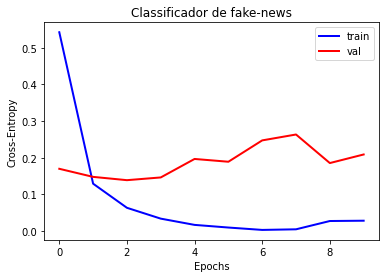

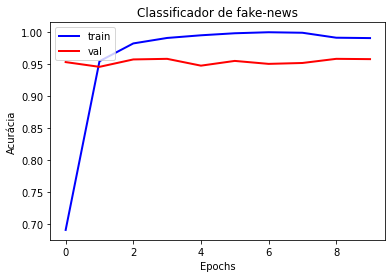

In [ ]:
hist = model.fit(
        X_train, 
        Y_train, 
        validation_data=(X_test, Y_test),
        epochs=10,
        batch_size=10, 
        shuffle=True,
        verbose=1)

model.save_weights(f"/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/modelo.h5")    


plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Classificador de fake-news')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Classificador de fake-news')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(loc='upper left')
plt.show()

Nuvem de palavras


In [ ]:
def generate_word_array(data, index):
  data_out = []
  for i in index:
    data_out.append(data[i])
  return " RU3451218 ".join(s for s in data_out)

In [ ]:
real_data = generate_word_array(x_text, real_index)
mask_real = np.array(Image.open(f"/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/afirmativo.png"))
real_cloud = WordCloud(
    mask = mask_real,
    background_color = "white",
    width=mask_real.shape[1],
    height=mask_real.shape[0], color_func=lambda *args, **kwargs: "green"
).generate(real_data)
fake_data = generate_word_array(x_text, fake_index)
mask_fake = np.array(Image.open(f"/content/drive/MyDrive/fake.br_corpus.zip (Unzipped Files)/fake.br_corpus/voto-negativo.png"))
fake_cloud = WordCloud(
    background_color = "white",
    mask = mask_fake,
    width=mask_fake.shape[1],
    height=mask_fake.shape[0], color_func=lambda *args, **kwargs: "red"
).generate(fake_data)

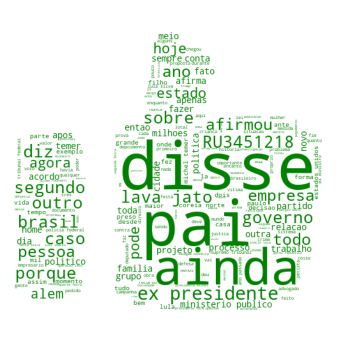

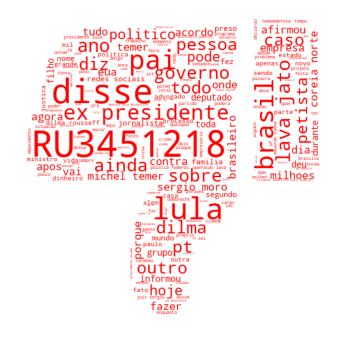

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(real_cloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(real_cloud)

fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(fake_cloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(fake_cloud)